In [ ]:
# Run this cell to install cellpose, then restart before running the code 
!pip install cellpose

Done. Saved masks and summary figure.


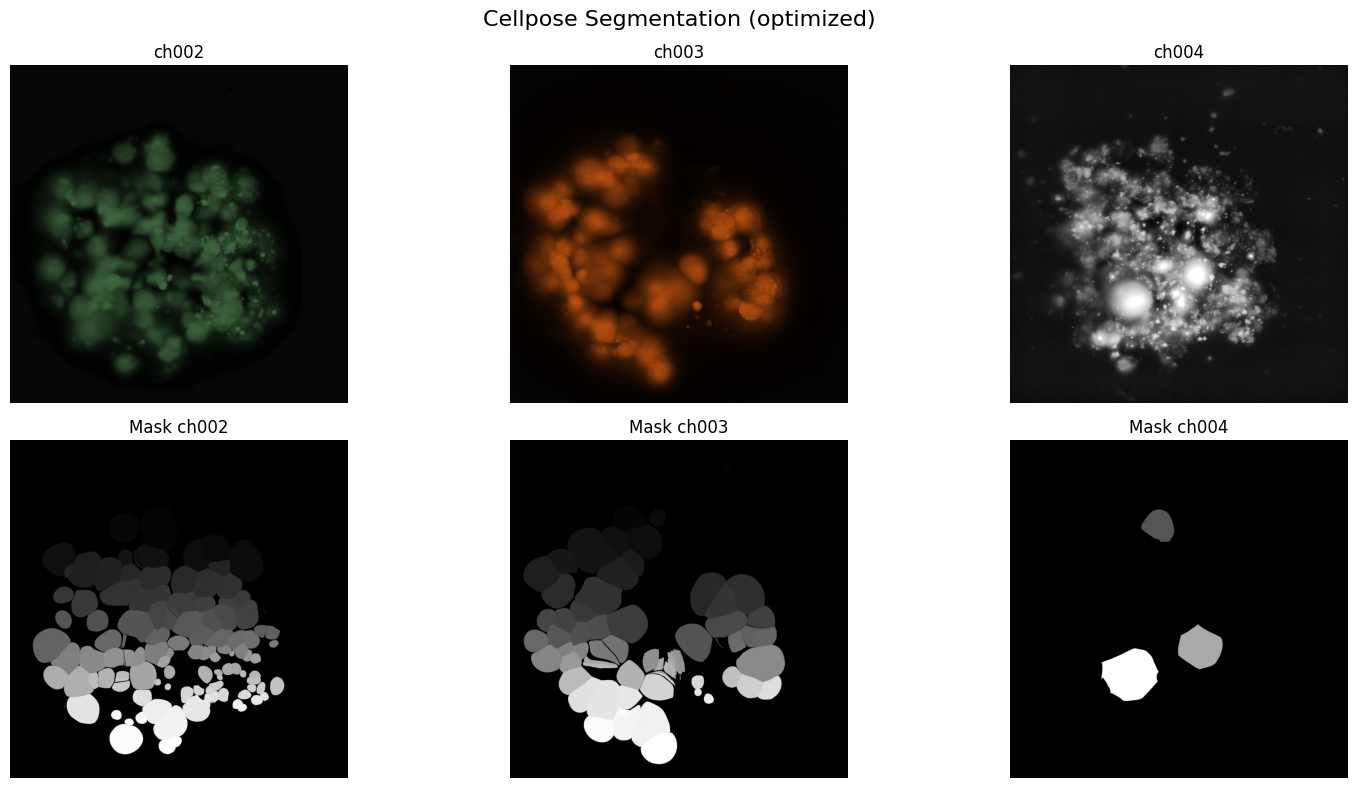

In [ ]:
#CELLPOSE TESTING: here I can select any image I am interested in and review the cellpose masks. 

import os
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models, io
from skimage import exposure, filters

# --- Paths ---
mip_folder = 'data/MIP'
output_folder = 'data/Segmentations/channels_cellpose'
os.makedirs(output_folder, exist_ok=True)

# --- Image selection ---
condition, timepoint, image_number = 'A', '24h', '001'
channel_suffixes = ['ch002', 'ch003', 'ch004']

params = {
    'ch002': {'diameter': 50,  'flow_threshold': 0.9, 'cellprob_threshold': -5},
    'ch003': {'diameter': 50, 'flow_threshold': 0.9, 'cellprob_threshold': -5},
    'ch004': {'diameter': 500, 'flow_threshold': 0.3, 'cellprob_threshold': 0}
}


def preprocess(img):
    img = exposure.equalize_adapthist(img, clip_limit=0.03)
    img = filters.gaussian(img, sigma=1)
    return img

# --- Model (GPU if available) ---
model = models.CellposeModel(gpu=True, model_type='cyto2')

fig, axes = plt.subplots(2, len(channel_suffixes), figsize=(16, 8))
fig.suptitle('Cellpose Segmentation (optimized)', fontsize=16)

for i, ch_suffix in enumerate(channel_suffixes):
    image_name = f'{condition}_{timepoint}_Image{image_number}_{ch_suffix}.tif'
    image_path = os.path.join(mip_folder, image_name)
    if not os.path.exists(image_path):
        print(f'Not found: {image_name}')
        continue

    img = preprocess(io.imread(image_path))
    p = params[ch_suffix]
    masks, flows, styles = model.eval(
        [img], diameter=p['diameter'], channels=[0, 0],
        flow_threshold=p['flow_threshold'], cellprob_threshold=p['cellprob_threshold']
    )
    masks = masks[0]

    # Save mask
    io.imsave(os.path.join(output_folder, f'{image_name}_mask.png'), masks.astype(np.uint8))

    # Show
    axes[0, i].imshow(img, cmap='gray'); axes[0, i].set_title(ch_suffix); axes[0, i].axis('off')
    axes[1, i].imshow(masks, cmap='gray'); axes[1, i].set_title(f'Mask {ch_suffix}'); axes[1, i].axis('off')

plt.tight_layout()
plt.savefig('cellpose_segmentation_plot.png')
print("Done. Saved masks and summary figure.")


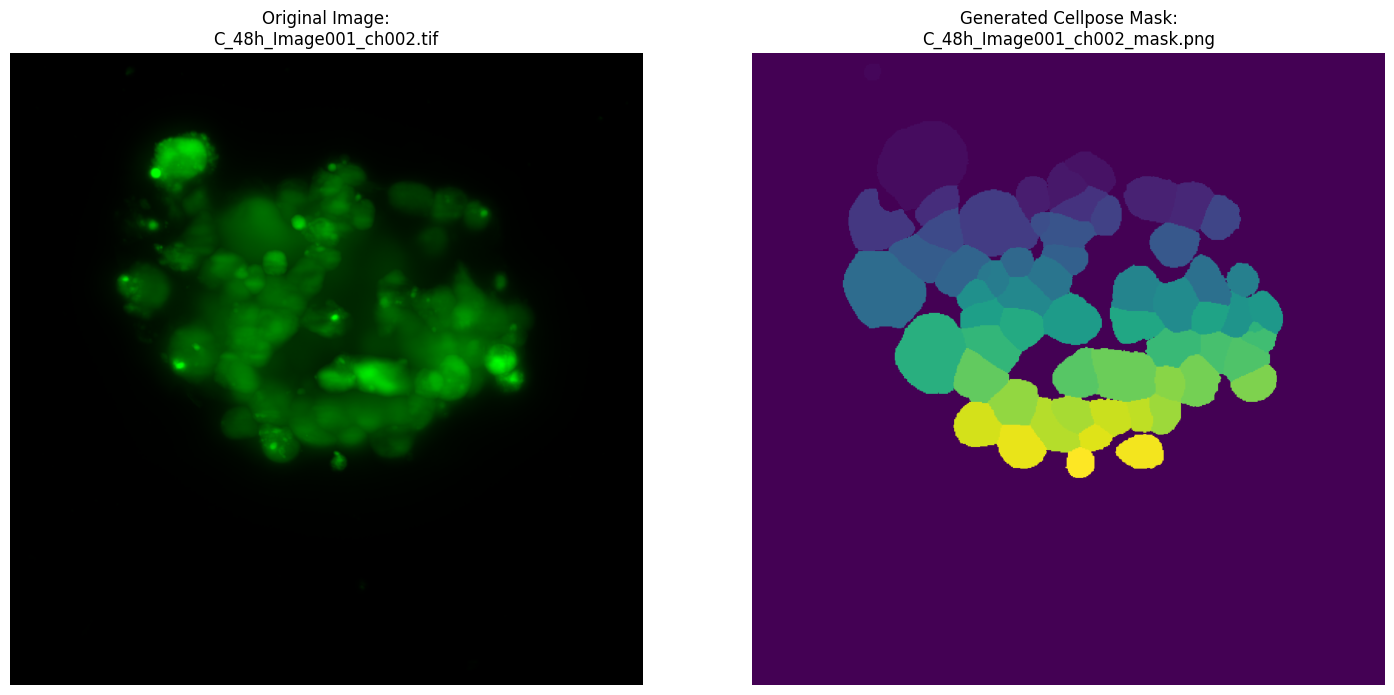

In [ ]:
#MASK VERIFICATION: here I can see the masks one by one, similar code to the above but more detailed view 

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

try:    
    condition = 'C'
    timepoint = '48h'
    image_number = '001'
    channel = 'ch002'

# Path to the original fluorescence channel image
    original_image_name = f'{condition}_{timepoint}_Image{image_number}_{channel}.tif'
    original_image_path = os.path.join('data', 'MIP', original_image_name)
# Path to the generated mask from the cellpose script
    mask_name = f'{condition}_{timepoint}_Image{image_number}_{channel}_mask.png'
    mask_path = os.path.join('data/Segmentations/channels_cellpose', mask_name)
# --- Load and display the images ---
    original_img = mpimg.imread(original_image_path)
    mask_img = mpimg.imread(mask_path)
# Create the side-by-side plot
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
 # Display the original channel image
    axes[0].imshow(original_img, cmap='gray')
    axes[0].set_title(f'Original Image:\n{original_image_name}')
    axes[0].axis('off')
# Display the Cellpose mask
# Using a colormap like 'viridis' helps distinguish the different cell IDs
    axes[1].imshow(mask_img, cmap='viridis')
    axes[1].set_title(f'Generated Cellpose Mask:\n{mask_name}')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
except FileNotFoundError:
    print("---")
    print("ERROR: Image or mask file not found.")
    print("Please make sure you have run the segmentation script successfully first.")
    print(f"The snippet is looking for these files:")
    print(f"1. {original_image_path}")
    print(f"2. {mask_path}")
    print("---")

In [ ]:
#actual cellpose segmentation here: must be run with GPU! 

import numpy as np
from cellpose import models, io
from skimage import exposure, filters, transform
import os, warnings

warnings.filterwarnings("ignore")

# --- Paths ---
mip_folder = 'data/MIP'
output_folder = 'data/Segmentations/channels_cellpose'
os.makedirs(output_folder, exist_ok=True)

# --- Image selection ---
conditions = ['A', 'B', 'C']
timepoints = ['24h', '48h', '96h']
image_numbers = ['001', '002', '003','004','005']
channel_suffixes = ['ch002', 'ch003', 'ch004']

# --- Cellpose Parameters ---
params = {
    'ch002': {'diameter': 50,  'flow_threshold': 0.9, 'cellprob_threshold': -5},
    'ch003': {'diameter': 50,  'flow_threshold': 0.9, 'cellprob_threshold': -5},
    'ch004': {'diameter': 150, 'flow_threshold': 0.3, 'cellprob_threshold': 0}
}

# --- Preprocessing Function ---
def preprocess(img):
    img = exposure.equalize_adapthist(img, clip_limit=0.03)
    img = filters.gaussian(img, sigma=1)
    # optional: downsample large images for speed
    if img.shape[0] > 1024 or img.shape[1] > 1024:
        img = transform.resize(img, (1024, 1024), anti_aliasing=True)
    return img.astype(np.float32)

# --- Model (GPU if available) ---
from cellpose import core, models
print("GPU available:", core.use_gpu())
print("Initializing model...")
model = models.CellposeModel(gpu=core.use_gpu())

# --- Main Processing Loop ---
for cond in conditions:
    for tp in timepoints:
        for img_num in image_numbers:
            for ch_suffix in channel_suffixes:
                image_name = f'{cond}_{tp}_Image{img_num}_{ch_suffix}.tif'
                image_path = os.path.join(mip_folder, image_name)
                
                if not os.path.exists(image_path):
                    continue

                print(f'Processing: {image_name}')
                img = preprocess(io.imread(image_path))
                p = params[ch_suffix]

                # Run Cellpose (single image mode)
                masks, flows, styles = model.eval(
                    img,
                    diameter=p['diameter'],
                    flow_threshold=p['flow_threshold'],
                    cellprob_threshold=p['cellprob_threshold'],
                    normalize=True,
                    resample=False,
                    batch_size=1,
                    progress=False
                )

                output_filename = f'{os.path.splitext(image_name)[0]}_mask.png'
                io.imsave(os.path.join(output_folder, output_filename), masks.astype(np.uint16))

print("\n✅ Done! All masks saved to:", output_folder)


GPU available: True
Initializing model...


100%|██████████| 1.15G/1.15G [00:54<00:00, 22.8MB/s] 


Processing: A_24h_Image001_ch002.tif
Processing: A_24h_Image001_ch003.tif
Processing: A_24h_Image001_ch004.tif
Processing: A_24h_Image002_ch002.tif
Processing: A_24h_Image002_ch003.tif
Processing: A_24h_Image002_ch004.tif
Processing: A_24h_Image003_ch002.tif
Processing: A_24h_Image003_ch003.tif
Processing: A_24h_Image003_ch004.tif
Processing: A_24h_Image004_ch002.tif
Processing: A_24h_Image004_ch003.tif
Processing: A_24h_Image004_ch004.tif
Processing: A_24h_Image005_ch002.tif
Processing: A_24h_Image005_ch003.tif
Processing: A_24h_Image005_ch004.tif
Processing: A_48h_Image001_ch002.tif
Processing: A_48h_Image001_ch003.tif
Processing: A_48h_Image001_ch004.tif
Processing: A_48h_Image002_ch002.tif
Processing: A_48h_Image002_ch003.tif
Processing: A_48h_Image002_ch004.tif
Processing: A_48h_Image003_ch002.tif
Processing: A_48h_Image003_ch003.tif
Processing: A_48h_Image003_ch004.tif
Processing: A_48h_Image004_ch002.tif
Processing: A_48h_Image004_ch003.tif
Processing: A_48h_Image004_ch004.tif
P

Saved the comparison plot to B_48h_Image005_comparison.png


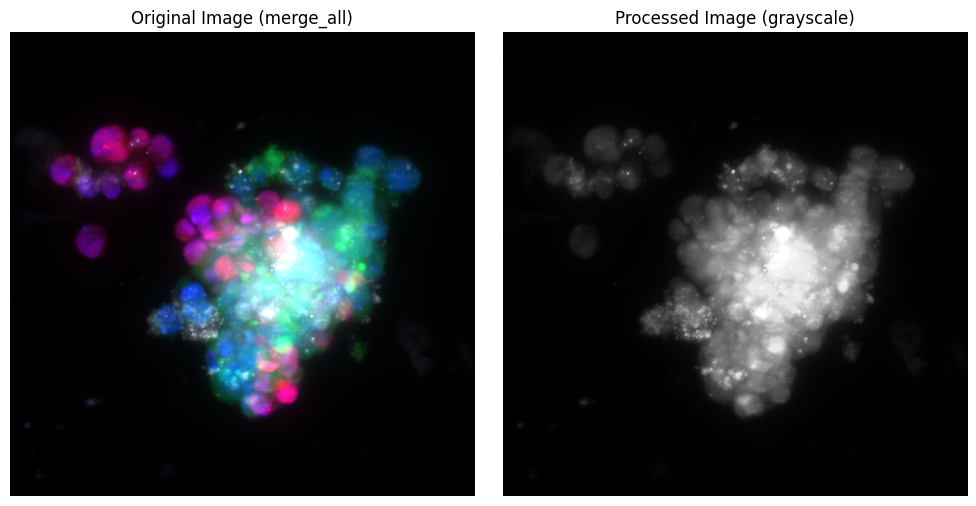

In [ ]:
#check whether the conversion from full chanel merged images to grayscale worked (produced images ..._comaprison.png)

import matplotlib.pyplot as plt                                                                         
import tifffile                                                                                           
import sys                                                                                                
import os                                    

base_name = "B_48h_Image005"

                                                                      
# Construct the paths for the original and processed images                                           
original_image_path = f"/content/drive/MyDrive/DDLS-Course/FinalProject/data/MIP/{base_name}_merge_all.tif"                                                                                           
processed_image_path = f"/content/drive/MyDrive/DDLS-Course/FinalProject/data/processed/images/{base_name}.tif"  

# Check if the files exist                                                                            
if not os.path.exists(original_image_path):                                                           
    print(f"Error: Original image not found at {original_image_path}")                                
                                                                                            
elif not os.path.exists(processed_image_path):                                                          
    print(f"Error: Processed image not found at {processed_image_path}")                              
else:                                                                                            
# Load the images                                                                                     
    original_image = tifffile.imread(original_image_path)                                                 
    processed_image = tifffile.imread(processed_image_path)                                               
 # Create a plot to compare the images                                                                 
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))                                                       
    axes[0].imshow(original_image)                                                                        
    axes[0].set_title("Original Image (merge_all)")                                                       
    axes[0].axis('off')                                                                                   
    axes[1].imshow(processed_image, cmap='gray')                                                          
    axes[1].set_title("Processed Image (grayscale)")                                                      
    axes[1].axis('off')                                                                                   
    plt.tight_layout()                                                                                    
    comparison_plot_path = f'{base_name}_comparison.png'                                                  
    plt.savefig(comparison_plot_path)                                                                     
    print(f"Saved the comparison plot to {comparison_plot_path}")                                         
 